In [1]:
import gpytorch
import torch

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use("ggplot")

In [2]:
def f(x): return (6*x-2)**2*torch.sin(12*x-4)

In [62]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(arg_num_dims=1)
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

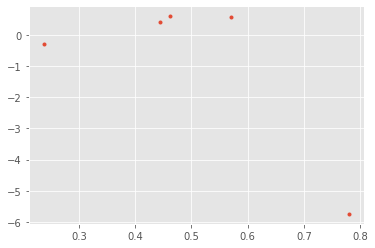

In [66]:
x_init = torch.rand(5,)
y_init = f(x_init)
plt.plot(x_init, y_init,'.')

In [67]:
model = ExactGPModel(x_init, y_init, gpytorch.likelihoods.GaussianLikelihood(noise=1e-3))

In [235]:
def optimise(model, method='lbfgs', max_iter=None):
    if method is 'lbfgs': optimise_lbfgs(model)
    if method is 'adam': optimise_adam(model) if max_iter is None else optimise_adam(model, max_iter)

def optimise_lbfgs(model):
    model.train()
#     model.likelihood.train()    
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    
    def closure():
        output = model(model.train_inputs[0])
        loss   = -mll(output, model.train_targets)
        opt.zero_grad()
        loss.backward()
        return loss
    opt = torch.optim.LBFGS([{'params':model.parameters()}], max_iter=1000)
    opt.step(closure)
    
def optimise_adam(model, max_iter=50):
    model.train()
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    opt = torch.optim.Adam([{'params':model.parameters()}], lr=0.1)
    for _ in range(max_iter):
        output = model(model.train_inputs[0])
        loss   = -mll(output, model.train_targets)
        opt.zero_grad()
        loss.backward()
        opt.step()

In [69]:
def plot_gp(*args):
    x_eval, model = (torch.linspace(0,1,100), args[0]) if len(args) < 2 else args
    
    model.eval()
    with torch.no_grad():
        f = model(x_eval)
        plt.plot(x_eval, f.mean.numpy(), 'b-')
        lci, uci = f.confidence_region()
        plt.fill_between(x_eval, lci.numpy(), uci.numpy(), alpha=0.1, color='b')
        plt.plot(model.train_inputs[0], model.train_targets, 'k.')

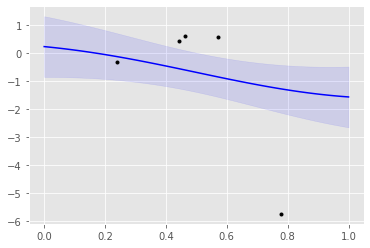

In [70]:
plot_gp(model)

In [71]:
optimise(model)

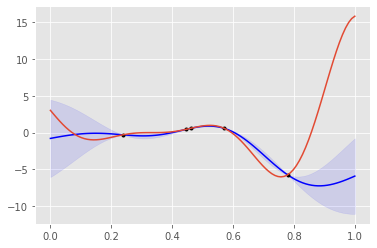

In [79]:
plot_gp(model)
plt.plot(torch.linspace(0,1,100),f(torch.linspace(0,1,100)))

In [97]:
def acq(fo, model):
    model.eval()
    x_eval = torch.linspace(0,1,100)
    f_ = model(x_eval)
    mu, Sig = f_.mean, f_.covariance_matrix
    
    fn = []
    for i in range(100):
        p_xi = torch.distributions.Normal(mu[i],Sig[i,i])
        fn.append((fo - mu[i])*p_xi.cdf(fo) + Sig[i,i]*p_xi.log_prob(fo).exp())
    return torch.stack(fn,0)

In [80]:
x_init.min()

tensor(0.2381)

In [89]:
with torch.no_grad():
    u = acq(x_init.min(), model)

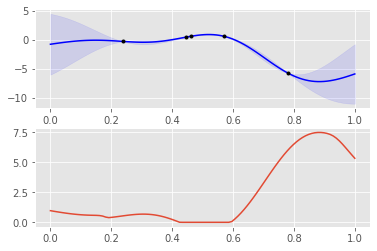

In [90]:
with torch.no_grad():
    plt.subplot(211)
    plot_gp(model)
    plt.subplot(212)
    plt.plot(torch.linspace(0,1,100),u)

In [93]:
x_eval = torch.linspace(0,1,100)
xn = x_eval[u.argmax()]

### Evaluation loop

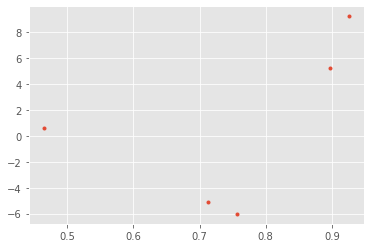

In [157]:
x_init = torch.rand(5,)
y_init = f(x_init)
plt.plot(x_init, y_init,'.')

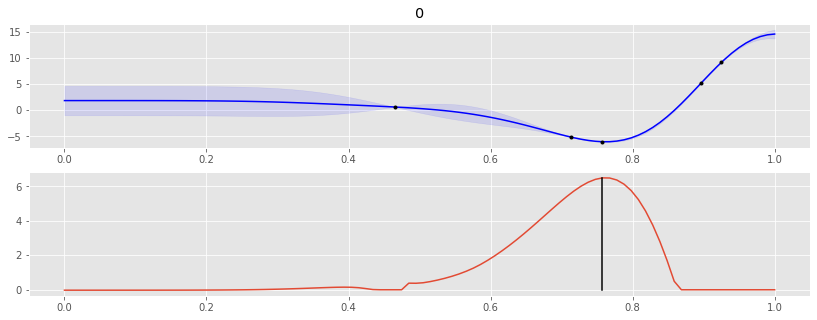

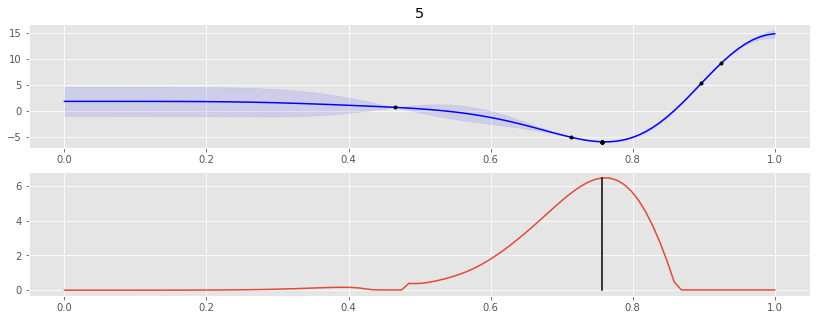

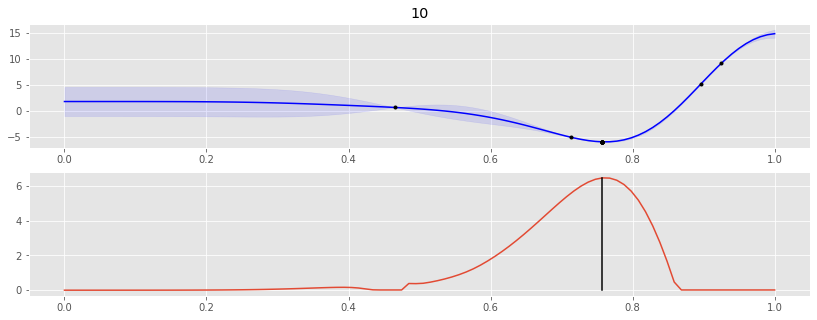

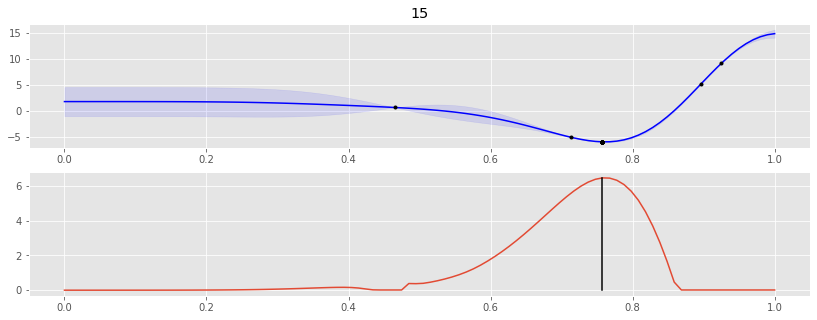

In [158]:
x_eval = torch.linspace(0,1,100)

x_train = x_init
y_train = y_init

Likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood

for i in range(20):
    
    model = ExactGPModel(
        x_train, y_train,
        Likelihood(noise=0.0001*torch.ones(len(x_train)))
    )
    optimise(model, method='adam')
    u = acq(y_train.min(), model)
    xn = x_eval[u.argmax()]
    if i % 5 == 0:
        plt.figure(figsize=(14,5))
        plt.subplot(211)
        plot_gp(model)
        plt.title(i)
        plt.subplot(212)
        plt.plot(x_eval, u.detach())
        plt.plot([xn.detach(),xn.detach()],[0,u.max().detach()],'k-')
    x_train = torch.stack([*x_train, xn])
    y_train = torch.stack([*y_train, f(xn)])

In [159]:
x_eval[f(x_eval).argmin()]

tensor(0.7576)

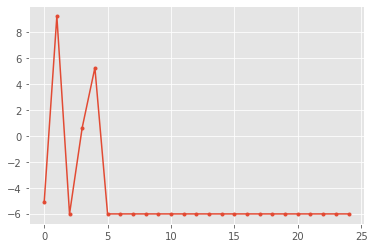

In [160]:
plt.plot(y_train,'.-')


### 3D experiment

In [166]:
alpha = torch.tensor([1., 1.2, 3., 3.2])
A = torch.tensor([[3.0, 10, 30],[0.1, 10, 35], [3.0, 10, 30], [0.1, 10, 35]])
P = 1e-4*torch.tensor([[3689, 1170, 2673],[4699, 4387, 7470],[1091, 8732, 5547],[381, 5743, 8828]])

def hf(x):
    f = torch.tensor(0.)
    for i in range(4):
        g = torch.tensor(0.)
        for j in range(3):
            g -= A[i,j]*(x[j]-P[i,j])**2
        f -= alpha[i]*torch.exp(g)
    return f

In [167]:
hf(torch.tensor([0.114614, 0.555649, 0.852547]))

tensor(-3.8628)

In [168]:
from pyDOE import lhs

In [213]:
N =10
x_init = torch.tensor(lhs(3, samples=10)).type(torch.FloatTensor)
y_init = torch.stack([hf(x_init[i,:]) for i in range(10)])

In [284]:
class ExactGPModel3(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel3, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(arg_num_dims=3)
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [262]:
# def acq(fo, model, x_eval=None):
#     model.eval()
#     if x_eval is None: 
#         x_eval = torch.linspace(0,1,100)
#     with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.lazily_evaluate_kernels(True):
#         f_ = model(x_eval)
#         mu, Sig = f_.mean, f_.variance#covariance_matrix
    
#     fn = []
#     for i in range(x_eval.shape[0]):
#         p_xi = torch.distributions.Normal(mu[i],Sig[i])
#         fn.append((fo - mu[i])*p_xi.cdf(fo) + Sig[i]*p_xi.log_prob(fo).exp())
#     return torch.stack(fn,0)

def acq(fo, model, x_eval=None):
    model.eval()
    if x_eval is None: x_eval = torch.linspace(0,1,100)
    with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.lazily_evaluate_kernels(True):
        f_ = model(x_eval)
        mu, sig = f_.mean, f_.variance#covariance_matrix
    
    _cdf = 0.5*(1+torch.erf((fo-mu)/(torch.sqrt(sig*2.))))
    _pdf = torch.exp(-(fo-mu)**2/(2*sig))/torch.sqrt(sig*2*3.141593)
    return (fo-mu)*_cdf + sig*_pdf

In [288]:
x_eval = torch.cat([x.reshape(-1,1) for x in torch.meshgrid(
    torch.linspace(0,1,100),
    torch.linspace(0,1,100),
    torch.linspace(0,1,100)
)],1)

x_train = x_init
y_train = y_init

Likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood

for i in range(50):
    
    model = ExactGPModel3(
        x_train, y_train,
        Likelihood(noise=0.0001*torch.ones(len(x_train)))
    )
    optimise(model, method='adam', max_iter=1000)
    u = acq(y_train.min(), model, x_eval)
#     print(u.shape)
    print(i)
    xn = x_eval[u.argmax(),:]
#     if i % 5 == 0:
#         plt.figure(figsize=(14,5))
#         plt.subplot(211)
#         plot_gp(model)
#         plt.title(i)
#         plt.subplot(212)
#         plt.plot(x_eval, u.detach())
#         plt.plot([xn.detach(),xn.detach()],[0,u.max().detach()],'k-')
    x_train = torch.cat([x_train, xn.reshape(1,-1)])
    y_train = torch.stack([*y_train, hf(xn)])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [289]:
x_train

tensor([[0.8060, 0.3780, 0.3187],
        [0.5111, 0.0796, 0.2505],
        [0.0568, 0.8307, 0.1266],
        [0.2095, 0.2205, 0.4233],
        [0.3175, 0.6815, 0.9761],
        [0.6063, 0.1928, 0.5332],
        [0.4011, 0.7817, 0.7198],
        [0.9363, 0.9882, 0.8584],
        [0.1992, 0.5064, 0.6522],
        [0.7965, 0.4102, 0.0615],
        [0.2626, 0.6667, 0.8182],
        [0.2020, 0.7071, 0.7980],
        [0.2929, 0.6263, 0.7980],
        [0.2525, 0.5960, 0.8283],
        [0.2222, 0.5556, 0.8586],
        [0.2525, 0.5253, 0.8687],
        [0.2222, 0.5657, 0.8788],
        [0.2222, 0.5455, 0.8485],
        [0.2222, 0.5455, 0.8485],
        [0.2222, 0.5455, 0.8485],
        [0.2323, 0.5455, 0.8485],
        [0.2222, 0.5455, 0.8485],
        [0.2222, 0.5455, 0.8485],
        [0.2323, 0.5455, 0.8485],
        [0.2222, 0.5455, 0.8485],
        [0.2222, 0.5455, 0.8485],
        [0.2323, 0.5455, 0.8485],
        [0.2222, 0.5455, 0.8485],
        [0.2222, 0.5556, 0.8485],
        [0.222

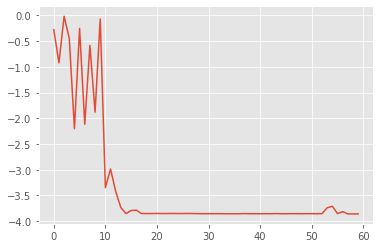

In [290]:
plt.plot(y_train)

In [291]:
y_train.min()

tensor(-3.8585)

In [292]:
hf(torch.tensor([0.114614, 0.555649, 0.852547]))

tensor(-3.8628)

In [293]:
x_train[y_train.argmin(),:]

tensor([0.0505, 0.5556, 0.8485])

In [294]:
y_eval = torch.stack([hf(x_eval[i,:]) for i in range(x_eval.shape[0])])

In [295]:
print(y_eval.min())
print(x_eval[y_eval.argmin(),:])

tensor(-3.8612)
tensor([0.1111, 0.5556, 0.8485])


In [301]:
torch.stack([torch.tensor(1.), *torch.zeros(3)],-1).unsqueeze(1).shape

torch.Size([4, 1])